In [56]:
%matplotlib inline
#from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
#from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.applications.vgg19 import preprocess_input, decode_predictions
from keras.layers import Dense, GlobalAveragePooling2D, GlobalMaxPooling2D,MaxPooling2D
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Input

from glob import glob
from itertools import cycle,zip_longest

import PIL
from PIL import Image
import matplotlib.pyplot as plt
import json
import time

from sklearn.cluster import KMeans

import numpy as np
import lda
import collections

from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import matplotlib
from sklearn.metrics.cluster import adjusted_rand_score
import seaborn as sns

## Data Processing - Create Batch Generator

In [2]:
#run extract_files.py to process the image files
total_image_number = 206900

## Process .json file with image labels 

In [3]:
def process_label_file():
    #with open("photos.json") as infile:
    with open("../photos.json") as infile:
      val = infile.readlines()

    id = []
    label = []
    for i in val:
      #print(i)
      #print("ID: %s, Label: %s" % (json.loads(i)['photo_id'],json.loads(i)['label']))
      id.append(json.loads(i)['photo_id'])
      label.append(json.loads(i)['label'])
    id = np.asarray(id)
    label = np.asarray(label)
    info = np.vstack((id,label))
    info = info.T
    info[0,:]
    return info

In [4]:
#align images with labels in used_im_labels array
def map_label_file_to_names(json_labels,names):
    process_names = names
    new_names = [(name.replace("/home/ubuntu/project/le49/photos/","")).replace(".jpg","") for name in process_names]
    used_im_labels = [json_labels[np.where(json_labels[:,0]==name)[0][0],1] for name in new_names]
    return np.asarray(used_im_labels)

In [5]:
info = process_label_file()

In [6]:
#used_im_labels = map_label_file_to_names(info,names)
#np.save('labels.npy', used_im_labels) 

In [7]:
used_im_labels = np.load('labels.npy')

In [8]:
#number of clusters
uniq_elem = np.unique(info[:,1])

## Define Model

In [9]:
# refer to extract_files.py for model definiton

## Load Extracted Features

In [10]:
#refer to extract_files.py for creation of these files
names = np.load('names.npy')

In [11]:
final_features_b2_av = np.load('predictions_block2_global.npy')

In [12]:
final_features_b5_av = np.load('predictions_block5_global.npy')

In [13]:
final_features_b2_max = np.load('predictions_block2_max.npy')

In [14]:
final_features_b5_max = np.load('predictions_block5_max.npy')

## Process features into word representations

** Process by normalising the rows and setting values > 0.5 to 1 otherwise 0 **

In [15]:
def process_features_with_normalising(final_features):
    processed_features_list = []
    mean = np.mean(final_features,axis=1)
    min = np.min(final_features,axis=1)
    max = np.max(final_features,axis=1)
    for row in range(final_features.shape[0]):
      if((100*row/final_features.shape[0]) % 10 == 0 and int(100*row/final_features.shape[0]) !=0):
          print("%s" % (int(100*row/final_features.shape[0])))
      normalised_row = [(image-min[row])/(max[row]-min[row]) for image in final_features[row,:]]
      discrete_row = [1 if image >= 0.5 else 0 for image in normalised_row]
      final_array_row = np.asarray(discrete_row)
      processed_features_list.append(final_array_row)
    return np.asarray(processed_features_list)

In [16]:
#processed_features_b5_av_norm = process_features_with_normalising(final_features_b5_av)
#processed_features_b5_max_norm = process_features_with_normalising(final_features_b5_max)
#processed_features_b2_av_norm = process_features_with_normalising(final_features_b2_av)
#processed_features_b2_max_norm = process_features_with_normalising(final_features_b2_max)

In [17]:
#np.save('processed_features_b5_av_norm.npy', processed_features_b5_av_norm) 
#np.save('processed_features_b5_max_norm.npy', processed_features_b5_max_norm) 
#np.save('processed_features_b2_av_norm.npy', processed_features_b2_av_norm) 
#np.save('processed_features_b2_max_norm.npy', processed_features_b2_max_norm) 

In [18]:
#processed_features_b5_av_norm = np.load('processed_features_b5_av_norm.npy')
#processed_features_b5_max_norm = np.load('processed_features_b5_max_norm.npy')
#processed_features_b2_av_norm = np.load('processed_features_b2_av_norm.npy')
#processed_features_b2_max_norm = np.load('processed_features_b2_max_norm.npy')

In [19]:
def process_features_with_counts(final_features):
    num_features = final_features.shape[1]
    return np.reshape(np.round(np.reshape(final_features,(total_image_number*num_features))),(total_image_number,num_features)).astype(int)

In [20]:
#processed_features_b5_av_counts = process_features_with_counts(final_features_b5_av)
#processed_features_b5_max_counts = process_features_with_counts(final_features_b5_max)
#processed_features_b2_av_counts = process_features_with_counts(final_features_b2_av)
#processed_features_b2_max_counts = process_features_with_counts(final_features_b2_max)

In [21]:
#np.save('processed_features_b5_av_counts.npy', processed_features_b5_av_counts) 
#np.save('processed_features_b5_max_counts.npy', processed_features_b5_max_counts) 
#np.save('processed_features_b2_av_counts.npy', processed_features_b2_av_counts) 
#np.save('processed_features_b2_max_counts.npy', processed_features_b2_max_counts) 

In [22]:
processed_features_b5_av_counts = np.load('processed_features_b5_av_counts.npy')
processed_features_b5_max_counts = np.load('processed_features_b5_max_counts.npy')
processed_features_b2_av_counts = np.load('processed_features_b2_av_counts.npy')
processed_features_b2_max_counts = np.load('processed_features_b2_max_counts.npy')

In [23]:
def regenerate_random_data_samples(total_samples,random_subset, features):
    subset_samples = []
    subset_labels = []
    random_subset_vals = []
    names_subset = []
    final_subset = features[random_subset][0,:,:]
    final_labels = used_im_labels[random_subset][0]
    final_names = names[random_subset][0]
    random_subset_vals.append(random_subset)
    return final_subset, final_labels, random_subset_vals,final_names


In [24]:
def generate_random_data_samples(total_samples, features):
    subset_samples = []
    subset_labels = []
    random_subset_vals = []
    names_subset = []
    random_subset = np.random.choice(range(0,processed_features.shape[0]), size=(total_samples), replace=False)
    final_subset = features[random_subset]
    final_labels = used_im_labels[random_subset]
    final_names = names[random_subset]
    random_subset_vals.append(random_subset)
    return final_subset, final_labels, random_subset_vals,final_names



In [57]:
#final_subset, final_labels, random_subset,names_subset= generate_random_data_samples(2000)

In [25]:
random_subset = np.load("subset_test1.npy") #~1% data (same distribution)!

In [26]:
final_subset_b5_av, final_labels, random_subset_val,names_subset = regenerate_random_data_samples(2000,random_subset,processed_features_b5_av_counts) # max 894


In [27]:
final_subset_b5_max, final_labels, random_subset_val,names_subset = regenerate_random_data_samples(2000,random_subset,processed_features_b5_max_counts) # max 894



In [28]:
final_subset_b2_av, final_labels, random_subset_val,names_subset = regenerate_random_data_samples(2000,random_subset,processed_features_b2_av_counts) # max 894 


## Do LDA on word representations

In [29]:
model_lda_b5_av_topic_c_10 = np.load("./final_data/model_lda_b5_av_topic_c_10.npy")
model_lda_b2_av_topic_c_10 = np.load("./final_data/model_lda_b2_av_topic_c_10.npy")
model_lda_b5_max_topic_c_10 = np.load("./final_data/model_lda_b5_max_topic_c_10.npy")
model_lda_b5_av_topic_c_5 = np.load("./final_data/model_lda_b5_av_topic_c_5.npy")
model_lda_b5_av_topic_c_40 = np.load("./final_data/model_lda_b5_av_topic_c_40.npy")
model_lda_b5_av_comp_c_10 = np.load("./final_data/model_lda_b5_av_comp_c_10.npy")
model_lda_b2_av_comp_c_10 = np.load("./final_data/model_lda_b2_av_comp_c_10.npy")
model_lda_b5_max_comp_c_10 = np.load("./final_data/model_lda_b5_max_comp_c_10.npy")
model_lda_b5_av_comp_c_5 = np.load("./final_data/model_lda_b5_av_comp_c_5.npy")
model_lda_b5_av_comp_c_40 = np.load("./final_data/model_lda_b5_av_comp_c_40.npy")
model_lda_b5_av_ndz_c_10 = np.load("./final_data/model_lda_b5_av_ndz_c_10.npy")
model_lda_b2_av_ndz_c_10 = np.load("./final_data/model_lda_b2_av_ndz_c_10.npy")
model_lda_b5_max_ndz_c_10 = np.load("./final_data/model_lda_b5_max_ndz_c_10.npy")
model_lda_b5_av_ndz_c_5 = np.load("./final_data/model_lda_b5_av_ndz_c_5.npy")
model_lda_b5_av_ndz_c_40 = np.load("./final_data/model_lda_b5_av_ndz_c_40.npy")


In [30]:
tsne_weights_b5_av_c_p40_5 = np.load("./final_data/tsne_weights_b5_av_c_p40_5.npy")
tsne_weights_b5_av_c_p40_40 = np.load("./final_data/tsne_weights_b5_av_c_p40_40.npy")
tsne_weights_b5_av_c_p40_10 = np.load("./final_data/tsne_weights_b5_av_c_p40_10.npy")
tsne_weights_b2_av_c_p40_10 = np.load("./final_data/tsne_weights_b2_av_c_p40_10.npy")
tsne_weights_b5_max_c_p40_10= np.load("./final_data/tsne_weights_b5_max_c_p40_10.npy")

In [31]:
labels_b2_av_c_p40_10 = np.load("./final_data/labels_b2_av_c_p40_10.npy")
labels_b5_av_c_p40_10 = np.load("./final_data/labels_b5_av_c_p40_10.npy")
labels_b5_av_c_p40_5 = np.load("./final_data/labels_b5_av_c_p40_5.npy")
labels_b5_av_c_p40_40 = np.load("./final_data/labels_b5_av_c_p40_40.npy")
labels_b5_max_c_p40_10 = np.load("./final_data/labels_b5_max_c_p40_10.npy")

In [32]:
std_lda_b5_av_c_10 = np.load("./final_data/std_lda_b5_av_c_10.npy")
std_lda_b2_av_c_10 = np.load("./final_data/std_lda_b2_av_c_10.npy")
std_lda_b5_max_c_10 = np.load("./final_data/std_lda_b5_max_c_10.npy")
std_lda_b5_av_c_5 = np.load("./final_data/std_lda_b5_av_c_5.npy")
std_lda_b5_av_c_40 = np.load("./final_data/std_lda_b5_av_c_40.npy")

In [33]:
model1 = model_lda_b2_av_topic_c_10
model2 = model_lda_b5_av_topic_c_40

In [34]:
lowDWeights1 = tsne_weights_b2_av_c_p40_10
lowDWeights2 = tsne_weights_b5_av_c_p40_40
labels1 = labels_b2_av_c_p40_10
labels2 = labels_b5_av_c_p40_40
class_count_1 = collections.Counter(labels1)
class_count_2 = collections.Counter(labels2)
std1 = std_lda_b5_av_c_5
std2 = std_lda_b5_av_c_40
mean1 = np.max(model1,axis=1)
mean2 = np.max(model2,axis=1)

In [35]:
yelp_labels = final_labels

In [36]:
adjusted_rand_score(np.argmax(model1,axis=1),np.argmax(model2,axis=1))

0.019381500476938703

In [37]:
def save_hist_plot_as_txt(x,y,fname):
    with open(fname, 'w') as f:
          f.write("x y\n")
          for i in range(x.shape[0]):
            if(i < y.shape[0]):
                f.write("%s %s\n" %(x[i],y[i]))
            else:
                f.write("%s\n" %(x[i]))
                print("here")

In [3]:
save_hist_plot_as_txt(plt.hist(std1,bins=40,alpha = 0.3,normed=True,color ='green')[1],plt.hist(std1,bins=40,alpha = 0.3,normed=True,color ='green')[0],"output_plots/test.txt")

NameError: name 'save_hist_plot_as_txt' is not defined

here


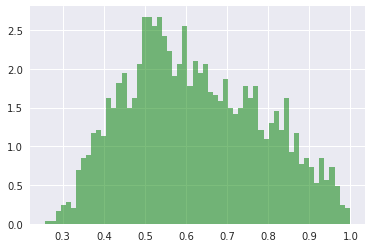

In [59]:
save_hist_plot_as_txt(plt.hist(mean1,bins=60,alpha = 0.3,normed=True,color ='green')[1],plt.hist(mean1,bins=60,alpha = 0.3,normed=True,color ='green')[0],"output_plots/b5_av_5_hist_60bins.txt")

## Visualisation of LDA wrt image labels

In [38]:
def save_tsne_plot_as_txt(tsne_low_dim_rep,labels1,labels2,fname):
    with open(fname, 'w') as f:
          f.write("x y l1 l2\n")
          for i in range(tsne_low_dim_rep.shape[0]):
            f.write("%s %s %s %s\n" %(tsne_low_dim_rep[i,0],tsne_low_dim_rep[i,1],labels1[i],labels2[i]))

In [31]:
save_tsne_plot_as_txt(tsne_weights_b5_av_c_p40_5,labels_b5_av_c_p40_5,new_labels,"./output_plots/tsne_b5_av_c_p40_5.txt")
save_tsne_plot_as_txt(tsne_weights_b5_av_c_p40_10,labels_b5_av_c_p40_10,new_labels,"./output_plots/tsne_b5_av_c_p40_10.txt")
save_tsne_plot_as_txt(tsne_weights_b5_av_c_p40_40,labels_b5_av_c_p40_40,new_labels,"./output_plots/tsne_b5_av_c_p40_40.txt")
save_tsne_plot_as_txt(tsne_weights_b5_max_c_p40_10,labels_b5_max_c_p40_10,new_labels,"./output_plots/tsne_b5_max_c_p40_10.txt")
save_tsne_plot_as_txt(tsne_weights_b2_av_c_p40_10,labels_b2_av_c_p40_10,new_labels,"./output_plots/tsne_b2_av_c_p40_10.txt")

In [40]:
new_labels = []
for label in yelp_labels:
    if label == 'menu': #negative
        new_labels.append(0)
    elif label == 'drink': #neutral
        new_labels.append(1)
    elif label == 'inside': #neutral
        new_labels.append(2)
    elif label == 'outside': #neutral
        new_labels.append(3)
    elif label == 'food': #neutral
        new_labels.append(4)
new_labels = np.asarray(new_labels)

In [41]:
labels_b2_av_c_p40_10 = np.load("./final_data/labels_b2_av_c_p40_10.npy")
labels_b5_av_c_p40_10 = np.load("./final_data/labels_b5_av_c_p40_10.npy")
labels_b5_av_c_p40_5 = np.load("./final_data/labels_b5_av_c_p40_5.npy")
labels_b5_av_c_p40_40 = np.load("./final_data/labels_b5_av_c_p40_40.npy")
labels_b5_max_c_p40_10 = np.load("./final_data/labels_b5_max_c_p40_10.npy")

In [42]:
tsne_weights_b5_av_c_p40_5 = np.load("./final_data/tsne_weights_b5_av_c_p40_5.npy")
tsne_weights_b5_av_c_p40_40 = np.load("./final_data/tsne_weights_b5_av_c_p40_40.npy")
tsne_weights_b5_av_c_p40_10 = np.load("./final_data/tsne_weights_b5_av_c_p40_10.npy")
tsne_weights_b2_av_c_p40_10 = np.load("./final_data/tsne_weights_b2_av_c_p40_10.npy")
tsne_weights_b5_max_c_p40_10= np.load("./final_data/tsne_weights_b5_max_c_p40_10.npy")

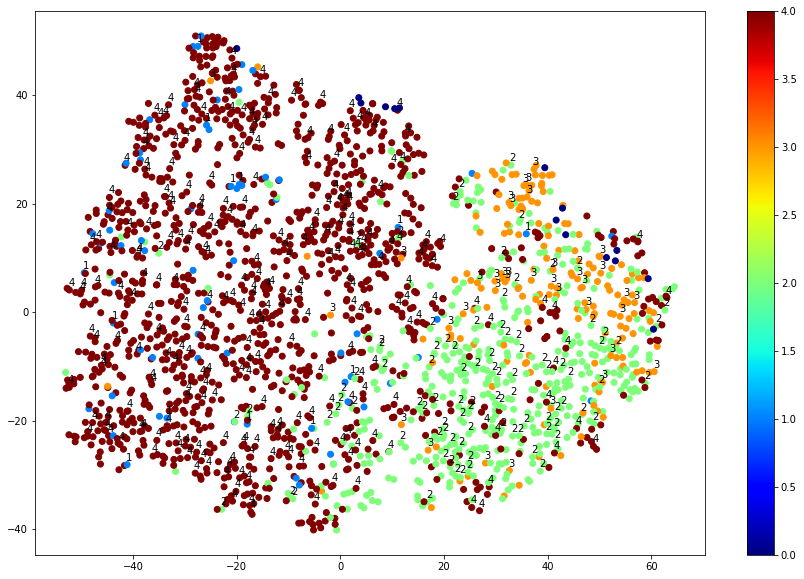

In [46]:
plt.figure(figsize=(15, 10))
plt.scatter(lowDWeights1[:,0],lowDWeights1[:,1],c=new_labels,cmap='jet')
plt.colorbar()
for i,label in enumerate(new_labels):
    x, y = lowDWeights1[i,:]
    if(i%5 == 0):
        plt.annotate(label,xy=(x,y),xytext=(5, 2),textcoords='offset points',ha='right',va='bottom')


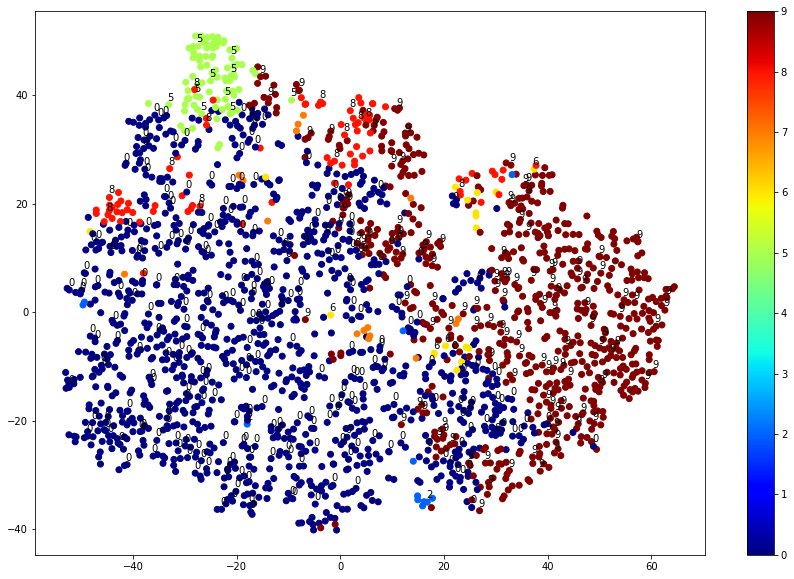

In [47]:
plt.figure(figsize=(15, 10))
plt.scatter(lowDWeights1[:,0],lowDWeights1[:,1],c=labels1,cmap='jet')
plt.colorbar()
for i,label in enumerate(labels1):
    x, y = lowDWeights1[i,:]
    if(i%5 == 0):
        plt.annotate(label,xy=(x,y),xytext=(5, 2),textcoords='offset points',ha='right',va='bottom')



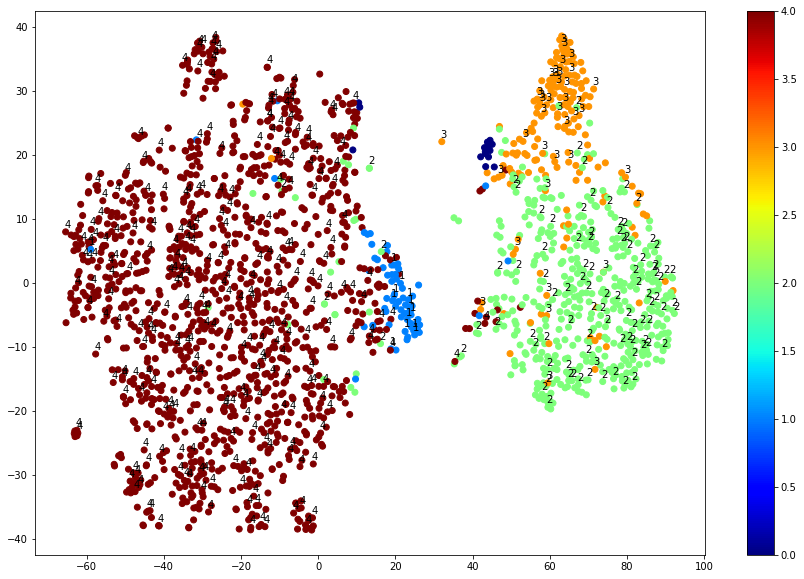

In [48]:
plt.figure(figsize=(15, 10))
plt.scatter(lowDWeights2[:,0],lowDWeights2[:,1],c=new_labels,cmap='jet')
plt.colorbar()
for i,label in enumerate(new_labels):
    x, y = lowDWeights2[i,:]
    if(i%5 == 0):
        plt.annotate(label,xy=(x,y),xytext=(5, 2),textcoords='offset points',ha='right',va='bottom')



39


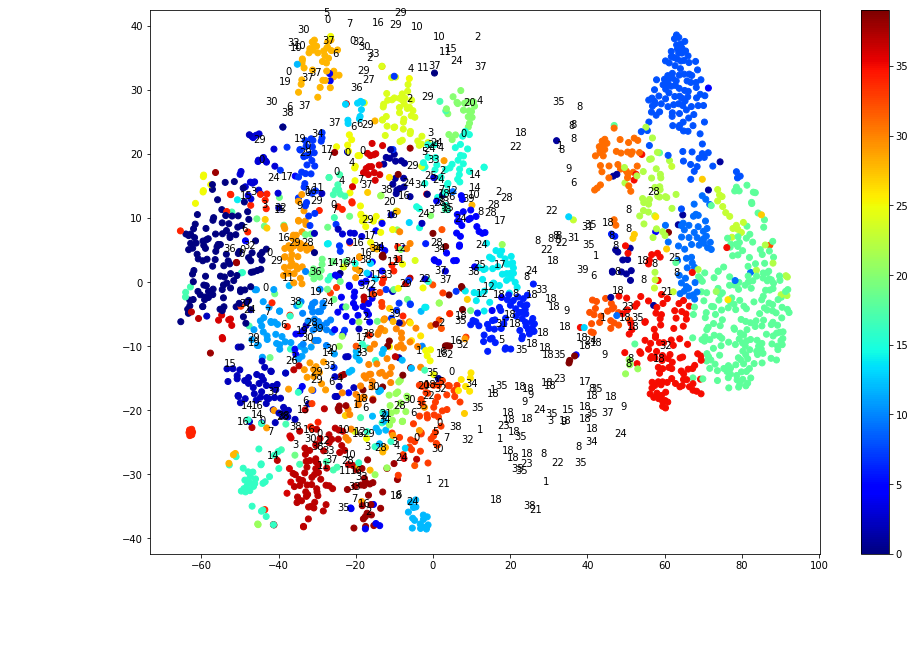

In [49]:
plt.figure(figsize=(15,10))
plt.scatter(lowDWeights2[:,0],lowDWeights2[:,1],c=labels2,cmap='jet')
plt.colorbar()
for i,label in enumerate(labels2):
    x, y = lowDWeights1[i,:]
    if(i%5 == 0):
       plt.annotate(label,xy=(x,y),xytext=(5, 2),textcoords='offset points',ha='right',va='bottom')




82
0: 74
1: 46
2: 29
3: 38
4: 21
5: 61
6: 26
7: 45
8: 39
9: 52
10: 76
11: 11
12: 43
13: 4
14: 50
15: 49
16: 12
17: 23
18: 31
19: 3


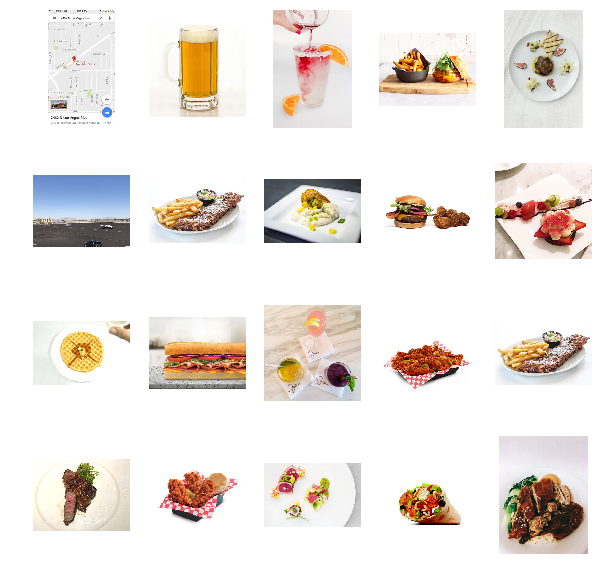

In [50]:
category = 5
option = 1
if option == 1:
    class_count = class_count_1[category]
    model = model1
else:
    class_count = class_count_2[category]
    model = model2
cat_ind = (np.argmax(model,axis=1) == category)
num_in_class = class_count
print(num_in_class)
if(num_in_class < 20):
    num_images = num_in_class
else:
    num_images = 20
with matplotlib.rc_context({'figure.figsize': [10,10], 'axes.titlesize': 10}):
    fig = plt.figure()
    val = np.random.choice(range(0,num_in_class),size=(num_images),replace=False)

    for i,num in enumerate(range(0,num_images)):
        print("%s: %s" %(i,val[i]))
        cat_names = names_subset[cat_ind] 
        img = PIL.Image.open(cat_names[val[i]])
        plt.subplot(4,5,i+1)
        plt.axis('off')
        plt.imshow(img)
        

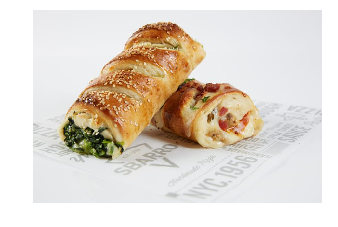

In [51]:
with matplotlib.rc_context({'figure.figsize': [30,25], 'axes.titlesize': 10}):
    fig = plt.figure()
    img = PIL.Image.open(names_subset[cat_ind][64])
    plt.subplot(4,5,i+1)
    plt.axis('off')
    plt.imshow(img)

In [52]:
image_num = 55

0


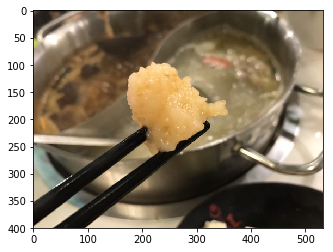

In [54]:
img = PIL.Image.open(names_subset[image_num])
plt.imshow(img)
class_val = np.argmax(model1[image_num,:])
print(class_val)

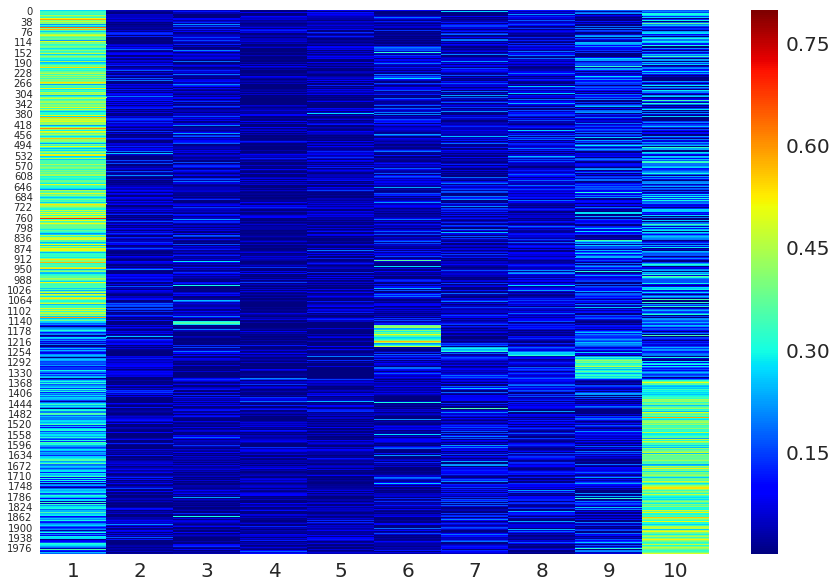

In [58]:
sns.set()
topic_ordered = np.argsort(np.argmax(model1,axis=1))
with matplotlib.rc_context({'figure.figsize': [15,10], 'axes.titlesize': 10}):
    fig = plt.figure()
    ax = sns.heatmap(model1[topic_ordered,:],cmap="jet")
    cax = plt.gcf().axes[-1]
    ax.set_xticklabels([1,2,3,4,5,6,7,8,9,10])
    cax.tick_params(labelsize=20)
    plt.xticks(fontsize=20)